In [ ]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import cv2
import gc
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense,GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading the preprocessed Dataset
train_data = '/content/drive/MyDrive/Resized'
test_data = '/content/drive/MyDrive/Test'


In [ ]:
train_counts = {expression: len(os.listdir(os.path.join(train_data, expression)))
                for expression in os.listdir(train_data)}
train_counts_df = pd.DataFrame(train_counts, index=['train'])
print("Number of images in training set:")
print(train_counts_df)

Number of images in training set:
       No_DR  Mild  Moderate  Severe  Proliferative_DR
train  22286  1903      4325     726               585


In [ ]:
test_counts = {expression: len(os.listdir(os.path.join(test_data, expression)))
                for expression in os.listdir(test_data)}
test_counts_df = pd.DataFrame(test_counts, index=['test'])
print("Number of images in testing set:")
print(test_counts_df)

Number of images in testing set:
      No_DR  Severe  Mild  Moderate  Proliferative_DR
test   1102     112   370       599               117


Text(0, 0.5, 'Count')

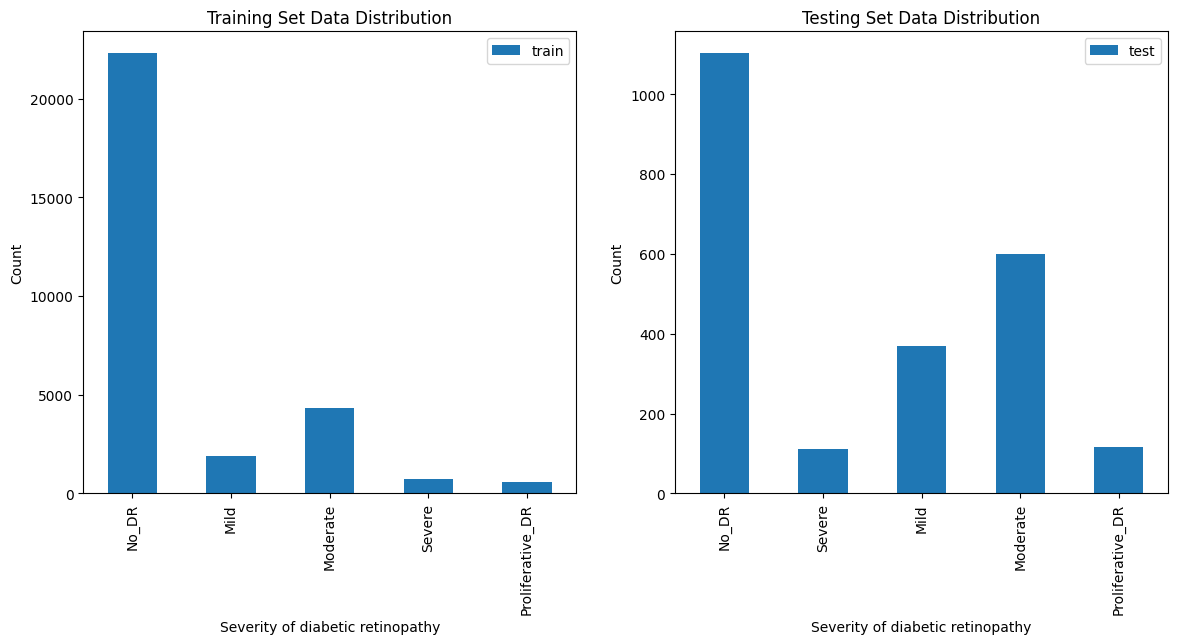

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
train_counts_df.transpose().plot(kind='bar', ax=plt.gca())
plt.title('Training Set Data Distribution')
plt.xlabel('Severity of diabetic retinopathy')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
test_counts_df.transpose().plot(kind='bar', ax=plt.gca())
plt.title('Testing Set Data Distribution')
plt.xlabel('Severity of diabetic retinopathy')
plt.ylabel('Count')

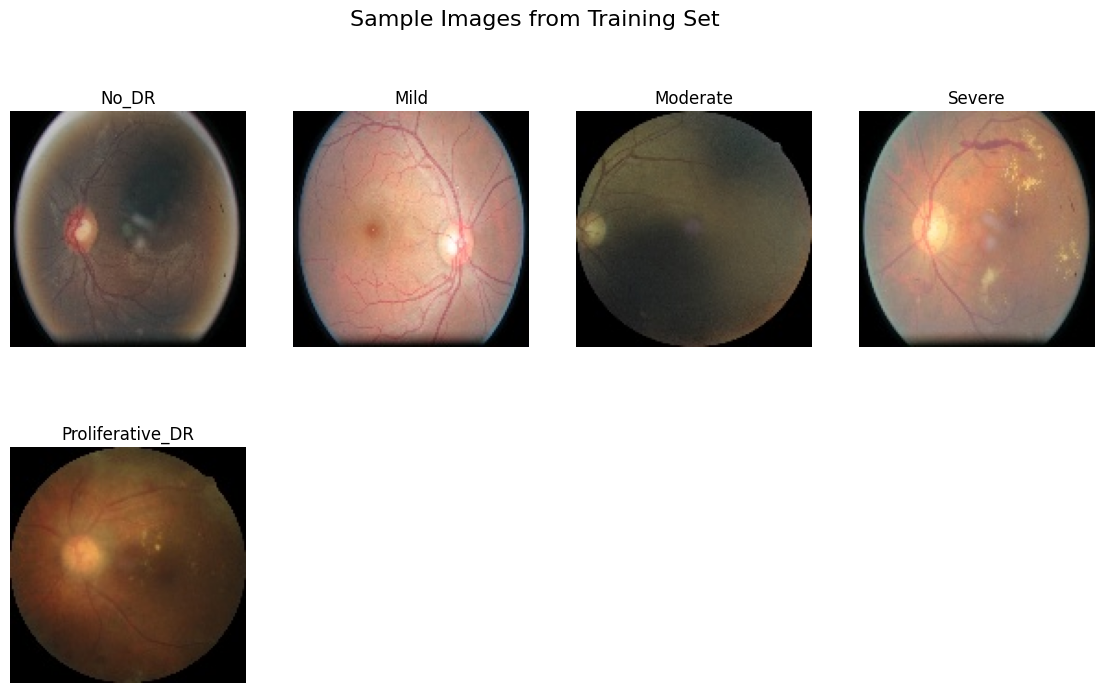

In [ ]:
plt.figure(figsize=(14, 8))
for i, expression in enumerate(os.listdir(train_data), 1):
    img_path = os.path.join(train_data, expression, os.listdir(os.path.join(train_data, expression))[0])
    img = plt.imread(img_path)
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(expression)
    plt.axis('off')
plt.suptitle('Sample Images from Training Set', fontsize=16)
plt.show()

In [ ]:
# Data preprocessing and augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    fill_mode='constant',
    cval=0.,
    rescale=1./255,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20 ,)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [ ]:
#image_generator
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(128, 128),
    batch_size=64,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(128, 128),
    batch_size=64,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False)

Found 29825 images belonging to 5 classes.
Found 2300 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.callbacks import Callback,ModelCheckpoint
from sklearn.metrics import cohen_kappa_score
import json

class kappa_metrics(Callback):
    def __init__(self, validation_data):
        super().__init__() #Call to super constructor
        self.val_kappas = []
        self.validation_data = validation_data

    def on_train_begin(self, logs={}):
        print("Training started...")  # Example initialization

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data
        y_val = np.argmax(y_val, axis=1) #Convert from one hot to categorical
        y_pred = (self.model.predict(X_val) > 0.5).astype(int)
        y_pred = np.argmax(y_pred, axis=1) #Convert from one hot to categorical

        _val_kappa = cohen_kappa_score(y_val, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)

        if self.val_kappas and _val_kappa == max(self.val_kappas): #Check if list is not empty
            self.model.save('model.h5')
        return


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2


def create_inceptionv3_model(input_shape=(128, 128, 3), num_classes=5, dropout_rate=0.5, l2_reg=1e-4):
    base_model = InceptionV3(weights='imagenet',
                             include_top=False,
                             input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze all layers initially

    for layer in base_model.layers[-30:]: # More layers for fine tuning
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x) # Batch Normalization after GAP
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate / 2)(x)  # Reduced dropout in the last Dense layer
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = create_inceptionv3_model()
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_188 (Conv2D)       │ (None, 63, 63, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_189   │ (None, 63, 63, 32)     │             96 │ conv2d_188[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_188            │ (None, 63, 63, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_189 (Conv2D)       │ (None, 61, 61, 32)     │          9,216 │ activation_188[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_190   │ (None, 61, 61, 32)     │             96 │ conv2d_189[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_189            │ (None, 61, 61, 32)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_190 (Conv2D)       │ (None, 61, 61, 64)     │         18,432 │ activation_189[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_191   │ (None, 61, 61, 64)     │            192 │ conv2d_190[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_190            │ (None, 61, 61, 64)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 30, 30, 64)     │              0 │ activation_190[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_191 (Conv2D)       │ (None, 30, 30, 80)     │          5,120 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_192   │ (None, 30, 30, 80)     │            240 │ conv2d_191[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_191            │ (None, 30, 30, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_192 (Conv2D)  

 Total params: 24,442,661 (93.24 MB)

 Trainable params: 7,788,741 (29.71 MB)

 Non-trainable params: 16,653,920 (63.53 MB)

In [ ]:
import datetime

log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint = callbacks.ModelCheckpoint('inceptionv3_model.keras', save_best_only=True, verbose=1, monitor='val_loss')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_delta=0.00001, verbose=1)
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = callbacks.CSVLogger('training.log')
kappa_metrics = kappa_metrics()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.n // test_generator.batch_size,
    callbacks=[ kappa_metrics, checkpoint, reduce_lr, csv_logger, tensorboard_callback, early_stopping],
)


In [ ]:
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

Test loss: 0.3910
Test accuracy: 0.8100


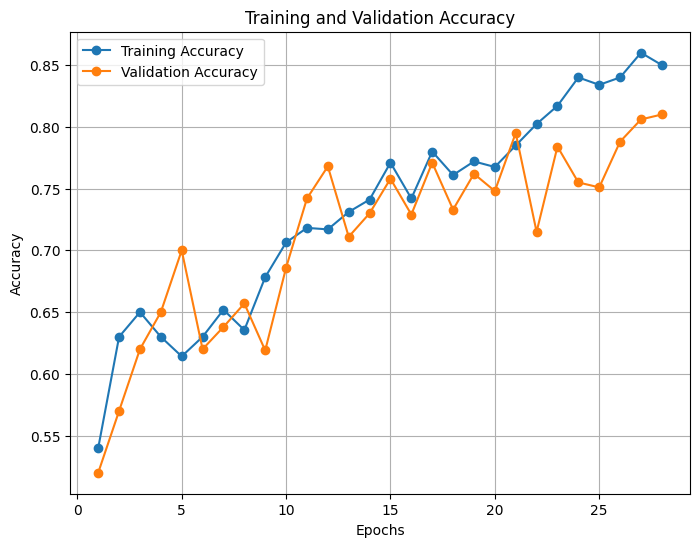

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = history['acc']
val_accuracy = history['val_acc']
train_loss = history['loss']
val_loss = history['val_loss']


# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot( train_accuracy, label='Training Accuracy', marker = 'o')
plt.plot( val_accuracy, label='Validation Accuracy', marker = 'o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


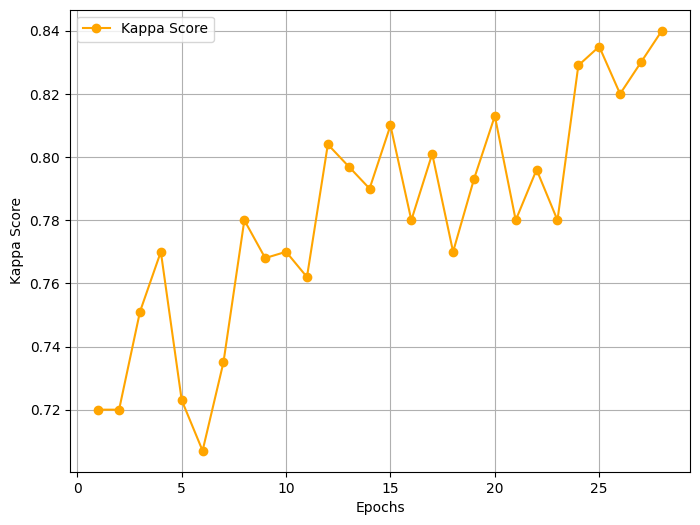

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(8,6))
plt.plot(kappa_metrics.val_kappas, label='Kappa Score',  color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Kappa Score')
plt.legend()
plt.grid(True)
plt.show()

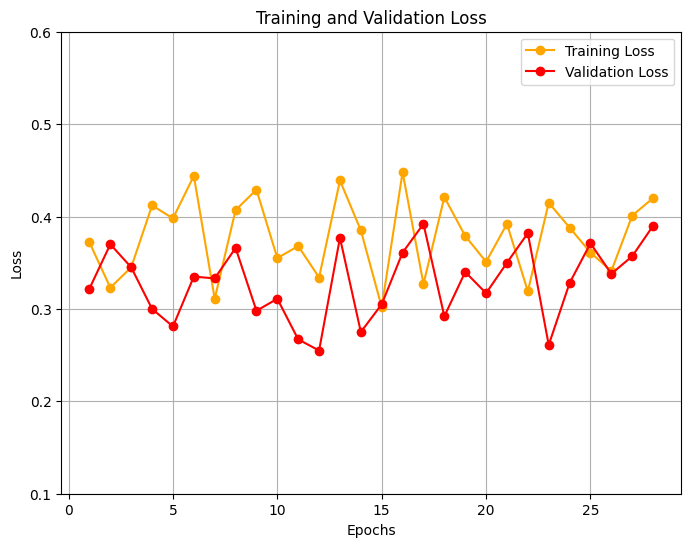

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(8,6))
plt.plot( train_loss, label='Training Loss',  color='orange', marker='o')
plt.plot( val_loss, label='Validation Loss',  color='red', marker='o')
plt.title('Training and Validation Loss')
plt.ylim(0.1, 0.6)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

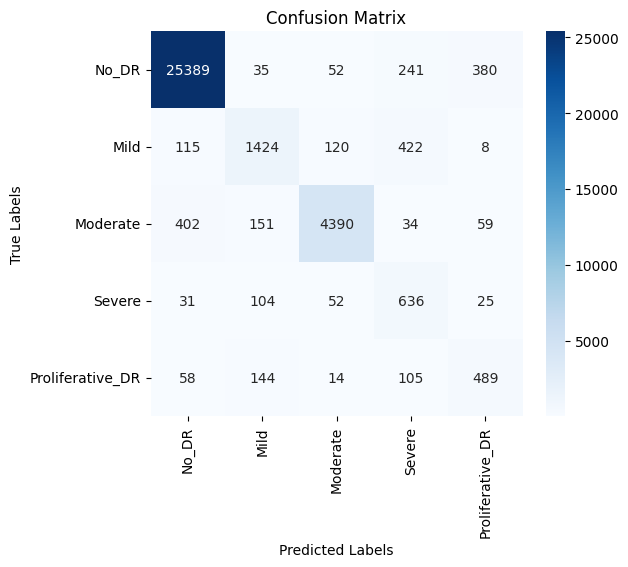

In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):

  plt.figure(figsize=(12, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=labels, yticklabels=labels)
  plt.title(title)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.tight_layout()
  plt.show()

validation_steps = len(test_generator)
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=validation_steps)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_true, y_pred)
labels = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']
plot_confusion_matrix(cm, labels)


In [ ]:
#save model
model_path = 'Inception3_model.h5'

# Save the model
model.save(model_path)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
